In [1]:
import pandas as pd
import numpy as np
import os 
from itertools import product
from tqdm.notebook import tqdm
import statsmodels.api as sm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
# from evaluate_func import *

In [2]:
market_data_train = pd.read_pickle('/code/20211027_alldays_market_data_cleanadd/market_data_train.pkl')

列表变量  
![jupyter](/code/task4-imbalance/111.png)
![jupyter](/code/task4-imbalance/222.png)

In [3]:
# # OFI计算函数,时间函数

# # 定义在第k个时间区间的数据

def time_to_second(time):
    h = time // 1e7
    min = time%1e7//1e5
    s = time % 1e5 /1e3
    result = 3600*h + 60*min+s
    return result

def second_to_time(second,add = True):       # 跳过11.30-13.00，分时间
    if add==False:
        if second>41400:
            second += 3600*1.5
    m, s = divmod(second, 60)
    h, m = divmod(m, 60)
    return h*1e7 + m*1e5 + s*1e3

def normal_time(time_window,t0=34200,time_len = 4*3600, add=True):
    time_list = [second_to_time(t0+time_window*x, add = add) for x in range(int(time_len/time_window)+1)]
    return time_list


In [ ]:
# check tmp
# OFI = {}
# delta_p = {}
# # variables
# date = 20191204
# code = 1
# time_window_first = 30*60     # 以三十分钟为时间间隔d，固定
# time_window = 10         # 10秒为小时间窗口
# dt=1
# time_list_first = normal_time(time_window=time_window_first, add = False)
# # time_list = normal_time(time_window=time_window)

# j = 2     # 第j个30min时间区间
# k=0       # 在第J个30min的区间中第k个小时间区间
# m = 1     # m 挡位价量数据

# # 先按照30分钟把每天分成几块，每一块内部进行划分delta p 和ofi计算

# time_index_first = np.argwhere((market_data_train[(date, code)][:,1]>time_list_first[j-1]) & (market_data_train[(date, code)][:,1]<=time_list_first[j]))

# data_tk = market_data_train[(date, code)][time_index_first.flatten()]      # data_code下这个30min时间区间的所有数据

# time_list = normal_time(time_window=time_window, t0 = time_to_second(data_tk[0,1]), time_len=0.5*3600)      # 
# time_index = np.argwhere((data_tk[:,1]>time_list[k-1]) & (data_tk[:,1]<=time_list[k]))


# W = []
# V = []
# e = []

# for tal in time_index.flatten()[1:]:
#     # W
#     if data_tk[tal,4+m] > data_tk[tal-1,4+m]:   # if b_m(tal_n) > b_m(tal_n-1) 
#         w = data_tk[tal, 14+m]
#     elif data_tk[tal,4+m] == data_tk[tal-1,4+m]:     # if b_m(tal_n) == b_m(tal_n-1) 
#         w = data_tk[tal, 14+m] - data_tk[tal-1, 14+m]
#     else:                                            # # if b_m(tal_n) < b_m(tal_n-1)                        
#         w = data_tk[tal-1, 14+m]

#     # V
#     if data_tk[tal, 9+m] > data_tk[tal-1, 9+m]:   # if a_m(tal_n) > a_m(tal_n-1) 
#         v = -data_tk[tal-1, 19+m]
#     elif data_tk[tal,4+m] == data_tk[tal-1,4+m]:     # if a_m(tal_n) == a_m(tal_n-1) 
#         v = data_tk[tal, 19+m] - data_tk[tal-1, 19+m]
#     else:                                            # # if a_m(tal_n) < a_m(tal_n-1)                        
#         v = data_tk[tal, 19+m]

#     W.append(w)
#     V.append(v)
#     e.append(w-v)
# OFI[k] = np.sum(e)
# delta_p[k] = data_tk[-1, 26] - data_tk[0, 26]


## check for one day

In [157]:
OFI = {}          # OFI字典，每个大时间段的第k个小时间段的OFI，两重索引，第j个大时间段，第k个小时间段，OFI[j][k] = [],列表内是五档数据
delta_p = {}      # delta_p字典，每个大时间段内第k个小时间段的delta_p,使用mid_price，两重索引，第j个大时间段，第k个小时间段，delta_p[j][k] = float()

# variables
date = 20191204     # 日期变量
code = 12            # 股票代码变量
time_window_first = 30*60     # 以三十分钟为时间间隔d，固定（大时间段的长度，每天的交易分成几个大时间段，每个大时间段内分别回归）
time_window = 10         # 10秒为小时间窗口 （每个大时间段内计算每个小时间段的OFI）
dt=1
time_list_first = normal_time(time_window=time_window_first, add = False)       # 大时间段列表

# 计算数据
for j in range(1,int(4*60*60 / time_window_first)+1):       # 对大时间段循环
    OFI[j] = {}
    delta_p[j] = {}

    data_tk = market_data_train[(date, code)][(market_data_train[(date, code)][:,1] > time_list_first[j-1]) & (market_data_train[(date, code)][:,1] <= time_list_first[j])] # 在这个大时间段内的索引
    time_list = normal_time(time_window=time_window, t0 = time_to_second(data_tk[0,1]), time_len=0.5*3600)      # 在这个大时间段内的小时间段列表
    # print(time_list)

    for k in range(1, len(time_list)):

        # print('time:',time_list[k-1])
        time_index = np.argwhere((data_tk[:,1]>time_list[k-1]) & (data_tk[:,1]<=time_list[k]))        # 小时间段对应的索引
        
        if len(time_index)>0:    # 如果对应时间段有交易
            OFI[j][k] = []

            delta_p[j][k] = round(data_tk[time_index[-1], 26][0] - data_tk[time_index[0], 26][0], 5)    # j个大时间段内的k个小时间段的delta_p
            
            for m in range(1,6):        # 第m档数据

                W = []
                V = []
                e = []

                for tal in time_index.flatten()[1:]:
                    # W
                    if data_tk[tal,4+m] > data_tk[tal-1,4+m]:   # if b_m(tal_n) > b_m(tal_n-1) 
                        w = data_tk[tal, 14+m]
                    elif data_tk[tal,4+m] == data_tk[tal-1,4+m]:     # if b_m(tal_n) == b_m(tal_n-1) 
                        w = data_tk[tal, 14+m] - data_tk[tal-1, 14+m]
                    else:                                            # # if b_m(tal_n) < b_m(tal_n-1)                        
                        w = data_tk[tal-1, 14+m]

                    # V
                    if data_tk[tal, 9+m] > data_tk[tal-1, 9+m]:   # if a_m(tal_n) > a_m(tal_n-1) 
                        v = -data_tk[tal-1, 19+m]
                    elif data_tk[tal,4+m] == data_tk[tal-1,4+m]:     # if a_m(tal_n) == a_m(tal_n-1) 
                        v = data_tk[tal, 19+m] - data_tk[tal-1, 19+m]
                    else:                                            # # if a_m(tal_n) < a_m(tal_n-1)                        
                        v = data_tk[tal, 19+m]

                    W.append(w)
                    V.append(v)
                    e.append(w-v)
                
                OFI[j][k].append(np.sum(e))

In [159]:
delta_p

{1: {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: -0.01,
  10: 0.0,
  11: 0.0,
  12: -0.01,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: 0.0,
  20: 0.0,
  21: 0.0,
  22: -0.01,
  23: 0.0,
  24: 0.0,
  25: 0.0,
  26: 0.0,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: 0.0,
  35: 0.0,
  36: 0.0,
  37: 0.0,
  38: 0.0,
  39: 0.0,
  40: 0.0,
  41: 0.0,
  42: 0.0,
  43: 0.0,
  44: -0.01,
  45: 0.01,
  46: 0.0,
  47: 0.0,
  48: 0.0,
  49: 0.0,
  50: 0.0,
  51: 0.0,
  52: 0.0,
  53: 0.0,
  54: 0.0,
  55: 0.0,
  56: 0.01,
  57: 0.0,
  58: 0.0,
  59: 0.0,
  60: 0.0,
  61: 0.0,
  62: -0.01,
  63: 0.0,
  64: 0.01,
  65: 0.0,
  66: 0.0,
  67: 0.01,
  68: 0.0,
  69: 0.0,
  70: 0.0,
  71: 0.0,
  72: -0.01,
  73: 0.0,
  74: 0.0,
  75: 0.0,
  76: 0.0,
  77: 0.0,
  78: 0.01,
  79: 0.0,
  80: 0.0,
  81: 0.0,
  82: 0.0,
  83: 0.0,
  84: 0.0,
  85: 0.0,
  86: 0.0,
  87: 0.0,
  88: 0.0,
  89: 0.0,
  90: 0.0,

In [162]:
data_tk[:,26]

array([4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.465, 4.465, 4.465, 4.465, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475, 4.475,
       4.475, 4.475,

In [160]:
time_list

[143003000.0,
 143013000.0,
 143023000.0,
 143033000.0,
 143043000.0,
 143053000.0,
 143103000.0,
 143113000.0,
 143123000.0,
 143133000.0,
 143143000.0,
 143153000.0,
 143203000.0,
 143213000.0,
 143223000.0,
 143233000.0,
 143243000.0,
 143253000.0,
 143303000.0,
 143313000.0,
 143323000.0,
 143333000.0,
 143343000.0,
 143353000.0,
 143403000.0,
 143413000.0,
 143423000.0,
 143433000.0,
 143443000.0,
 143453000.0,
 143503000.0,
 143513000.0,
 143523000.0,
 143533000.0,
 143543000.0,
 143553000.0,
 143603000.0,
 143613000.0,
 143623000.0,
 143633000.0,
 143643000.0,
 143653000.0,
 143703000.0,
 143713000.0,
 143723000.0,
 143733000.0,
 143743000.0,
 143753000.0,
 143803000.0,
 143813000.0,
 143823000.0,
 143833000.0,
 143843000.0,
 143853000.0,
 143903000.0,
 143913000.0,
 143923000.0,
 143933000.0,
 143943000.0,
 143953000.0,
 144003000.0,
 144013000.0,
 144023000.0,
 144033000.0,
 144043000.0,
 144053000.0,
 144103000.0,
 144113000.0,
 144123000.0,
 144133000.0,
 144143000.0,
 14415

In [161]:
data_tk[:,1]

array([1.43003e+08, 1.43018e+08, 1.43024e+08, 1.43027e+08, 1.43030e+08,
       1.43036e+08, 1.43039e+08, 1.43042e+08, 1.43045e+08, 1.43048e+08,
       1.43054e+08, 1.43057e+08, 1.43100e+08, 1.43106e+08, 1.43109e+08,
       1.43118e+08, 1.43124e+08, 1.43127e+08, 1.43130e+08, 1.43133e+08,
       1.43142e+08, 1.43148e+08, 1.43151e+08, 1.43157e+08, 1.43200e+08,
       1.43203e+08, 1.43209e+08, 1.43212e+08, 1.43215e+08, 1.43218e+08,
       1.43221e+08, 1.43224e+08, 1.43227e+08, 1.43230e+08, 1.43233e+08,
       1.43236e+08, 1.43239e+08, 1.43242e+08, 1.43248e+08, 1.43303e+08,
       1.43306e+08, 1.43309e+08, 1.43312e+08, 1.43315e+08, 1.43318e+08,
       1.43321e+08, 1.43324e+08, 1.43327e+08, 1.43330e+08, 1.43333e+08,
       1.43348e+08, 1.43351e+08, 1.43354e+08, 1.43357e+08, 1.43400e+08,
       1.43403e+08, 1.43406e+08, 1.43409e+08, 1.43412e+08, 1.43415e+08,
       1.43418e+08, 1.43421e+08, 1.43427e+08, 1.43430e+08, 1.43433e+08,
       1.43436e+08, 1.43439e+08, 1.43442e+08, 1.43448e+08, 1.434

## ofi summary

In [4]:
# 函数总结
def ofi_dp_generate(date, code, time_window_first=30*60, time_window=10):
    OFI = {}          # OFI字典，每个大时间段的第k个小时间段的OFI，两重索引，第j个大时间段，第k个小时间段，OFI[j][k] = [],列表内是五档数据
    delta_p = {}      # delta_p字典，每个大时间段内第k个小时间段的delta_p,使用mid_price，两重索引，第j个大时间段，第k个小时间段，delta_p[j][k] = float()

    # variables
    date = date     # 日期变量
    code = code            # 股票代码变量
    time_window_first = time_window_first     # 以三十分钟为时间间隔d，固定（大时间段的长度，每天的交易分成几个大时间段，每个大时间段内分别回归）
    time_window = time_window         # 10秒为小时间窗口 （每个大时间段内计算每个小时间段的OFI）
    dt=1
    time_list_first = normal_time(time_window=time_window_first, add = False)       # 大时间段列表

    # 计算数据
    for j in range(1,int(4*60*60 / time_window_first)+1):       # 对大时间段循环
        OFI[j] = {}
        delta_p[j] = {}

        data_tk = market_data_train[(date, code)][(market_data_train[(date, code)][:,1] > time_list_first[j-1]) & (market_data_train[(date, code)][:,1] <= time_list_first[j])] # 在这个大时间段内的索引
        time_list = normal_time(time_window=time_window, t0 = time_to_second(data_tk[0,1]), time_len=0.5*3600)      # 在这个大时间段内的小时间段列表
        # print(time_list)

        for k in range(1, len(time_list)):

            # print('time:',time_list[k-1])
            time_index = np.argwhere((data_tk[:,1]>time_list[k-1]) & (data_tk[:,1]<=time_list[k]))        # 小时间段对应的索引
            
            if len(time_index)>0:    # 如果对应时间段有交易
                OFI[j][k] = []

                delta_p[j][k] = round(data_tk[time_index[-1], 26][0] - data_tk[time_index[0], 26][0], 5)    # j个大时间段内的k个小时间段的delta_p
                
                for m in range(1,6):        # 第m档数据

                    W = []
                    V = []
                    e = []

                    for tal in time_index.flatten()[1:]:
                        # W
                        if data_tk[tal,4+m] > data_tk[tal-1,4+m]:   # if b_m(tal_n) > b_m(tal_n-1) 
                            w = data_tk[tal, 14+m]
                        elif data_tk[tal,4+m] == data_tk[tal-1,4+m]:     # if b_m(tal_n) == b_m(tal_n-1) 
                            w = data_tk[tal, 14+m] - data_tk[tal-1, 14+m]
                        else:                                            # # if b_m(tal_n) < b_m(tal_n-1)                        
                            w = data_tk[tal-1, 14+m]

                        # V
                        if data_tk[tal, 9+m] > data_tk[tal-1, 9+m]:   # if a_m(tal_n) > a_m(tal_n-1) 
                            v = -data_tk[tal-1, 19+m]
                        elif data_tk[tal,4+m] == data_tk[tal-1,4+m]:     # if a_m(tal_n) == a_m(tal_n-1) 
                            v = data_tk[tal, 19+m] - data_tk[tal-1, 19+m]
                        else:                                            # # if a_m(tal_n) < a_m(tal_n-1)                        
                            v = data_tk[tal, 19+m]

                        W.append(w)
                        V.append(v)
                        e.append(w-v)
                    
                    OFI[j][k].append(np.sum(e))
                
                    # print(j, time_index[-1], time_index[0])
    return OFI, delta_p           


## check 正确与否

In [61]:
delta_p[8]

{1: 0.005,
 2: 0.01,
 3: 0.005,
 4: 0.015,
 5: 0.0,
 6: -0.02,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: -0.005,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.005,
 17: -0.01,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: -0.005,
 23: -0.005,
 24: -0.005,
 25: 0.015,
 26: 0.005,
 27: 0.0,
 28: 0.015,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: -0.01,
 34: -0.005,
 35: 0.0,
 36: 0.0,
 37: 0.01,
 38: 0.0,
 39: -0.01,
 40: 0.005,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.005,
 49: 0.005,
 50: -0.005,
 51: 0.0,
 52: 0.0,
 53: -0.005,
 54: 0.0,
 55: 0.005,
 56: 0.0,
 57: -0.005,
 58: 0.0,
 59: 0.005,
 60: -0.01,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.01,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: -0.01,
 72: 0.0,
 73: -0.01,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.01,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.01,
 86: 0.0,
 87: -0.01,
 88: 0.01,
 89: -0.005,
 90: 0.0,
 91: -0.005,
 92: 0.0,
 93: 0.0,
 94

In [62]:
OFI[8]

{1: [-9000.0, 37900.0, -40500.0, -20600.0, -111091.0],
 2: [700.0, 211600.0, 211100.0, 427400.0, 165409.0],
 3: [-8400.0, 164300.0, 195600.0, 276700.0, 199918.0],
 4: [2800.0, 133800.0, 131800.0, 126600.0, 165609.0],
 5: [-5500.0, 269100.0, 262900.0, 253200.0, 330718.0],
 6: [-53700.0, 89700.0, -16200.0, -24291.0, -37991.0],
 7: [10800.0, 0.0, 0.0, 0.0, 0.0],
 8: [2300.0, 0.0, 100.0, 300.0, 0.0],
 9: [1000.0, -15700.0, -3000.0, 0.0, 0.0],
 10: [-1400.0, -4000.0, 1200.0, -1000.0, 0.0],
 11: [-21400.0, 72100.0, 70900.0, -28100.0, 101100.0],
 12: [-43400.0, 9100.0, 4100.0, 0.0, -1400.0],
 13: [5100.0, 800.0, 0.0, 0.0, 0.0],
 14: [24000.0, 32200.0, 105300.0, 175100.0, 148000.0],
 15: [23000.0, 12800.0, 104400.0, 175200.0, 151800.0],
 16: [800.0, 29400.0, 25100.0, 104400.0, 175600.0],
 17: [-38900.0, 50900.0, 84900.0, 56809.0, 50400.0],
 18: [-14700.0, 0.0, -10000.0, -1700.0, 2000.0],
 19: [-4900.0, 0.0, 0.0, 100.0, 0.0],
 20: [4000.0, -300.0, 0.0, 0.0, 0.0],
 21: [-8000.0, -3100.0, -6800.0

In [64]:
data_tk[:,1]

array([1.43003e+08, 1.43006e+08, 1.43009e+08, 1.43012e+08, 1.43015e+08,
       1.43018e+08, 1.43021e+08, 1.43024e+08, 1.43027e+08, 1.43030e+08,
       1.43033e+08, 1.43036e+08, 1.43039e+08, 1.43042e+08, 1.43045e+08,
       1.43048e+08, 1.43051e+08, 1.43054e+08, 1.43057e+08, 1.43100e+08,
       1.43103e+08, 1.43106e+08, 1.43109e+08, 1.43112e+08, 1.43115e+08,
       1.43118e+08, 1.43121e+08, 1.43124e+08, 1.43127e+08, 1.43130e+08,
       1.43133e+08, 1.43136e+08, 1.43139e+08, 1.43142e+08, 1.43145e+08,
       1.43148e+08, 1.43151e+08, 1.43154e+08, 1.43157e+08, 1.43200e+08,
       1.43203e+08, 1.43206e+08, 1.43209e+08, 1.43212e+08, 1.43215e+08,
       1.43218e+08, 1.43221e+08, 1.43224e+08, 1.43227e+08, 1.43230e+08,
       1.43233e+08, 1.43236e+08, 1.43239e+08, 1.43242e+08, 1.43245e+08,
       1.43248e+08, 1.43251e+08, 1.43254e+08, 1.43257e+08, 1.43300e+08,
       1.43303e+08, 1.43306e+08, 1.43309e+08, 1.43312e+08, 1.43315e+08,
       1.43318e+08, 1.43321e+08, 1.43324e+08, 1.43327e+08, 1.433

In [65]:
time_list

[143003000.0,
 143013000.0,
 143023000.0,
 143033000.0,
 143043000.0,
 143053000.0,
 143103000.0,
 143113000.0,
 143123000.0,
 143133000.0,
 143143000.0,
 143153000.0,
 143203000.0,
 143213000.0,
 143223000.0,
 143233000.0,
 143243000.0,
 143253000.0,
 143303000.0,
 143313000.0,
 143323000.0,
 143333000.0,
 143343000.0,
 143353000.0,
 143403000.0,
 143413000.0,
 143423000.0,
 143433000.0,
 143443000.0,
 143453000.0,
 143503000.0,
 143513000.0,
 143523000.0,
 143533000.0,
 143543000.0,
 143553000.0,
 143603000.0,
 143613000.0,
 143623000.0,
 143633000.0,
 143643000.0,
 143653000.0,
 143703000.0,
 143713000.0,
 143723000.0,
 143733000.0,
 143743000.0,
 143753000.0,
 143803000.0,
 143813000.0,
 143823000.0,
 143833000.0,
 143843000.0,
 143853000.0,
 143903000.0,
 143913000.0,
 143923000.0,
 143933000.0,
 143943000.0,
 143953000.0,
 144003000.0,
 144013000.0,
 144023000.0,
 144033000.0,
 144043000.0,
 144053000.0,
 144103000.0,
 144113000.0,
 144123000.0,
 144133000.0,
 144143000.0,
 14415

In [66]:
data_tk[:,26]

array([15.295, 15.3  , 15.3  , 15.305, 15.295, 15.315, 15.305, 15.295,
       15.315, 15.315, 15.3  , 15.3  , 15.305, 15.315, 15.3  , 15.315,
       15.3  , 15.305, 15.3  , 15.3  , 15.285, 15.285, 15.285, 15.285,
       15.285, 15.285, 15.285, 15.285, 15.285, 15.285, 15.285, 15.285,
       15.285, 15.285, 15.295, 15.29 , 15.29 , 15.29 , 15.29 , 15.29 ,
       15.29 , 15.285, 15.285, 15.285, 15.285, 15.29 , 15.285, 15.285,
       15.285, 15.29 , 15.285, 15.285, 15.285, 15.29 , 15.295, 15.285,
       15.285, 15.285, 15.285, 15.285, 15.285, 15.285, 15.285, 15.285,
       15.275, 15.275, 15.275, 15.275, 15.275, 15.275, 15.275, 15.28 ,
       15.28 , 15.275, 15.285, 15.28 , 15.28 , 15.28 , 15.285, 15.285,
       15.275, 15.275, 15.285, 15.29 , 15.285, 15.29 , 15.29 , 15.29 ,
       15.29 , 15.29 , 15.29 , 15.29 , 15.29 , 15.305, 15.305, 15.305,
       15.305, 15.305, 15.305, 15.305, 15.305, 15.295, 15.285, 15.295,
       15.285, 15.285, 15.285, 15.295, 15.295, 15.285, 15.285, 15.29 ,
      

In [69]:
ofi_dp_generate(20191204, 1)

time: 93003000.0
time: 93013000.0
time: 93023000.0
time: 93033000.0
time: 93043000.0
time: 93053000.0
time: 93103000.0
time: 93113000.0
time: 93123000.0
time: 93133000.0
time: 93143000.0
time: 93153000.0
time: 93203000.0
time: 93213000.0
time: 93223000.0
time: 93233000.0
time: 93243000.0
time: 93253000.0
time: 93303000.0
time: 93313000.0
time: 93323000.0
time: 93333000.0
time: 93343000.0
time: 93353000.0
time: 93403000.0
time: 93413000.0
time: 93423000.0
time: 93433000.0
time: 93443000.0
time: 93453000.0
time: 93503000.0
time: 93513000.0
time: 93523000.0
time: 93533000.0
time: 93543000.0
time: 93553000.0
time: 93603000.0
time: 93613000.0
time: 93623000.0
time: 93633000.0
time: 93643000.0
time: 93653000.0
time: 93703000.0
time: 93713000.0
time: 93723000.0
time: 93733000.0
time: 93743000.0
time: 93753000.0
time: 93803000.0
time: 93813000.0
time: 93823000.0
time: 93833000.0
time: 93843000.0
time: 93853000.0
time: 93903000.0
time: 93913000.0
time: 93923000.0
time: 93933000.0
time: 93943000

In [71]:
ofi[8]

{1: [-9000.0, 37900.0, -40500.0, -20600.0, -111091.0],
 2: [700.0, 211600.0, 211100.0, 427400.0, 165409.0],
 3: [-8400.0, 164300.0, 195600.0, 276700.0, 199918.0],
 4: [2800.0, 133800.0, 131800.0, 126600.0, 165609.0],
 5: [-5500.0, 269100.0, 262900.0, 253200.0, 330718.0],
 6: [-53700.0, 89700.0, -16200.0, -24291.0, -37991.0],
 7: [10800.0, 0.0, 0.0, 0.0, 0.0],
 8: [2300.0, 0.0, 100.0, 300.0, 0.0],
 9: [1000.0, -15700.0, -3000.0, 0.0, 0.0],
 10: [-1400.0, -4000.0, 1200.0, -1000.0, 0.0],
 11: [-21400.0, 72100.0, 70900.0, -28100.0, 101100.0],
 12: [-43400.0, 9100.0, 4100.0, 0.0, -1400.0],
 13: [5100.0, 800.0, 0.0, 0.0, 0.0],
 14: [24000.0, 32200.0, 105300.0, 175100.0, 148000.0],
 15: [23000.0, 12800.0, 104400.0, 175200.0, 151800.0],
 16: [800.0, 29400.0, 25100.0, 104400.0, 175600.0],
 17: [-38900.0, 50900.0, 84900.0, 56809.0, 50400.0],
 18: [-14700.0, 0.0, -10000.0, -1700.0, 2000.0],
 19: [-4900.0, 0.0, 0.0, 100.0, 0.0],
 20: [4000.0, -300.0, 0.0, 0.0, 0.0],
 21: [-8000.0, -3100.0, -6800.0

In [72]:
dp[8]

{1: 0.005,
 2: 0.01,
 3: 0.005,
 4: 0.015,
 5: 0.0,
 6: -0.02,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: -0.005,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.005,
 17: -0.01,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: -0.005,
 23: -0.005,
 24: -0.005,
 25: 0.015,
 26: 0.005,
 27: 0.0,
 28: 0.015,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: -0.01,
 34: -0.005,
 35: 0.0,
 36: 0.0,
 37: 0.01,
 38: 0.0,
 39: -0.01,
 40: 0.005,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.005,
 49: 0.005,
 50: -0.005,
 51: 0.0,
 52: 0.0,
 53: -0.005,
 54: 0.0,
 55: 0.005,
 56: 0.0,
 57: -0.005,
 58: 0.0,
 59: 0.005,
 60: -0.01,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.01,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: -0.01,
 72: 0.0,
 73: -0.01,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.01,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.01,
 86: 0.0,
 87: -0.01,
 88: 0.01,
 89: -0.005,
 90: 0.0,
 91: -0.005,
 92: 0.0,
 93: 0.0,
 94

# check OFI 和 delta_p的相关关系

In [5]:
# 定义函数查看m档OFI的平均R2
def r2_check(x,time_window=10):
    date = x[0]
    code=x[1]
    ofi, dp = ofi_dp_generate(date, code, time_window = time_window)
    m_r2 = []    # m档数据的r2
    
    for m in range(1,6):
        tmp_r2 = []     # 暂时存储m档数据对应j时间段的r2
        for i in range(1,9):     # 按照半小时为大时间段，每天共8个时间段
            # print(i, m)
            # x = pd.concat([pd.Series(x) for x in ofi[i].values()],axis=1).T.iloc[:,:m].reset_index(drop=True)    # i时间段内的m档ofi数据,m最大是5
            x = pd.DataFrame(ofi[i]).T.iloc[:,:m]
            y  = pd.Series(dp[i])#.reset_index(drop=True)      # i时间段内的delta_p数据
            if y.count()>0 and len(x.dropna())>0:
                model = sm.OLS(y, sm.add_constant(x),missing='drop')
                m_fit = model.fit()
                r2 = m_fit.rsquared
                tmp_r2.append(r2)       # 
            # print(np.mean(tmp_r2))
        m_r2.append(np.mean(tmp_r2))    # 8个时间段内的r2平均值 
    return m_r2

In [186]:
r2, ofi, dp = r2_check(20191204, 1, time_window=10)
r2.count()

[0.03884289873576828,
 0.11668068559044845,
 0.15441502253516015,
 0.19154792307318164,
 0.2145064129326555]

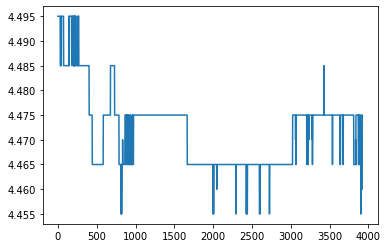

In [168]:
plt.plot(aa[:,26])       # 价格一直保持不变，所以ols回归没有结果

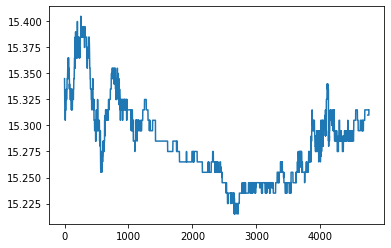

In [170]:
plt.plot(aa[:,26])     # code=1

In [193]:
# 遍历所有股票
# list(set([x[0] for x in market_data_train.keys()]))
len(list(np.unique([x[1] for x in market_data_train.keys()])))


400

In [ ]:
market_data_train.keys()

In [6]:
with Pool(32) as pool:
    part_result = pool.map(r2_check, list(market_data_train.keys()))

In [7]:
r2_result = pd.concat([pd.Series(x) for x in part_result],axis=1).T

In [8]:
r2_result.index = [x[1] for x in market_data_train.keys()]
r2_result

,0,1,2,3,4
1,0.038843,0.116681,0.154415,0.191548,0.214506
12,NaN,NaN,NaN,NaN,NaN
45,0.089307,0.452378,0.684910,0.729197,0.766442
63,0.148120,0.229836,0.286287,0.317868,0.363281
68,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
688068,0.102619,0.130325,0.156668,0.193075,0.197890
688081,0.166614,0.212820,0.237008,0.282574,0.325490
688168,0.074473,0.119453,0.138827,0.181670,0.231036
688310,0.094146,0.127836,0.190047,0.241626,0.253131


In [26]:
r2_result.describe()

,0,1,2,3,4
count,36977.000000,3.692400e+04,3.682500e+04,36785.000000,36749.000000
mean,0.086312,-inf,-inf,0.354733,0.402611
std,0.036864,NaN,NaN,0.179710,0.198352
min,0.003390,-inf,-inf,0.059032,0.068015
25%,0.060582,1.382718e-01,1.825996e-01,0.216286,0.244386
50%,0.083029,1.836176e-01,2.499876e-01,0.301203,0.344815
75%,0.107473,2.628164e-01,3.739275e-01,0.460082,0.533211
max,0.563917,8.295708e-01,9.762281e-01,0.988300,0.997116


In [10]:
r2_result.sort_index().to_csv('mean_r2_result.csv')

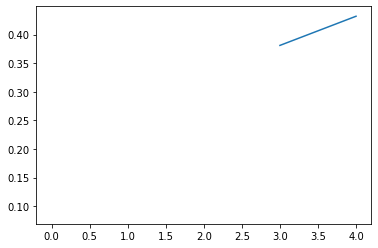

In [13]:
r2_mean_stock = r2_result.groupby(level=0).mean()
plt.plot(r2_mean_stock.mean())

In [24]:
r2_result_mean_allday_allstock = r2_mean_stock.replace([np.inf, -np.inf], [0,0]).mean()
r2_result_mean_allday_allstock.index = range(1,6)
r2_result_mean_allday_allstock = pd.DataFrame(r2_result_mean_allday_allstock,columns = ['R2'])
r2_result_mean_allday_allstock.index.names = ['OFI_n']
r2_result_mean_allday_allstock


,R2
OFI_n,
1,0.086379
2,0.226982
3,0.315245
4,0.381037
5,0.432016


# 打label + 输入数据构建

In [217]:
# 见test2kkkkk
